# Explorando el dataset MNIST de reconocimiento de dígitos

In [1]:
import numpy as np
import pandas as pd

In [2]:

x = pd.DataFrame(data = {'X':[1,2,3], 'Y':[4,5,6]})

In [3]:
x

,X,Y
0,1,4
1,2,5
2,3,6


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist


%matplotlib inline

C:\Users\huama\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
(x_train, y_train), (x_test, y_test)=mnist.load_data()


4


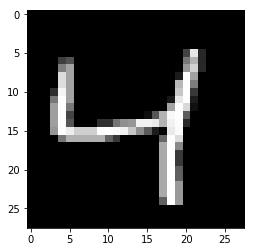

In [6]:
# Visualizamos parte de la información disponible:
plt.imshow(x_train[2], 'gray')
print(y_train[2])

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [8]:
# Probando el funcionamiento de los diversos métodos de reshaing de numpy:
aoc = np.array(np.random.normal(size = 12)).reshape([2,3,2])
aoc

array([[[-1.01940251, -0.87665736],
        [ 0.05078155,  1.04001121],
        [ 0.16245861, -0.84944716]],

       [[ 0.8560556 ,  0.62664396],
        [-0.91457766, -1.0926775 ],
        [-0.13621568,  1.54255937]]])

In [9]:
aoc = aoc.reshape([2,3*2])
aoc

array([[-1.01940251, -0.87665736,  0.05078155,  1.04001121,  0.16245861,
        -0.84944716],
       [ 0.8560556 ,  0.62664396, -0.91457766, -1.0926775 , -0.13621568,
         1.54255937]])

In [10]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Le damos un formato **"largo"** a la matriz que representa la imagen con el fin de poder ingresarlo en una red neuronal:

In [11]:
# Debemos estirar los datos para generar un vector para poder estandarizar y luego realizar
# el diseño de las capas:

x_train = x_train.reshape([60000, 28*28])
x_test = x_test.reshape([10000, 28*28])

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [12]:
# Normalización
mu = x_train.mean()
sigma = x_train.std()

x_train = (x_train - mu) / sigma
x_test = (x_test - mu) / sigma

x_train.mean(), x_test.mean(), x_train.std(), x_test.std()

(-3.064638490070051e-17,
 0.0060177948928480576,
 0.9999999999999998,
 1.0077000453879372)

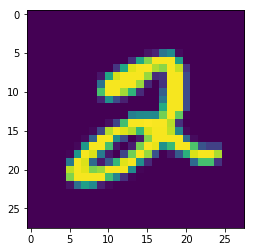

In [13]:
# Podemos volrer a visualizar la imagen si reescalamos el vector a una matriz :)
plt.imshow(x_train[5].reshape([28,28]))

# Ahora definimos un modelo sencillo para clasificar imágenes
Nuestro modelo se basará en un perceptrón múltiple con activación RELU, Leaky RELU y Sigmoidal en la ultima capa. La idea es ir iterando para verificar cómo varía la función de pérdida "Cross-Entropy"

In [81]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD # El más básico

# Establecemos los hiperparámetros:
lr = 0.01 # por default
batch_size = 256 # Es la cantidad de imágenes que se van a pasar COMO UN SOLO GRUPO en cada iteración
epochs=100 # Es la cantidad de iteraciones que se van a realizar. Se suelen limitar por temas de tiempo de procesamiento
num_batches = np.ceil(x_train.shape[0] / batch_size) # El número de GRUPOS que se pasarán en caso entrenemos todo el dataset

model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(SGD(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Experimento:

La idea es entrenar el modelo utilizando un ratio arbitrario de aprendizaje (en este caso, 0.01) y entrenar un modelo. A continuación, entrenar otro modelo utilizando la técnica de **learning rate finder** y comparar los resultados en términos de precisión.

Para ello, primero definiremos una función que nos permitirá obtener las gráficas adecuadas para poder realizar la comparación:

In [82]:
# Definiendo la función de graficación:

def show_results(model, log, cycling = False):
    """Esta función permite visualizar la evolución del valor de la función de pérdida y la precisión en los sets de
    entrenamiento y validación, a lo largo de las iteraciones propias del proceso de entrenamiento"""
    loss, acc = model.evaluate(x=x_test, y=y_test, batch_size = 512) # Este bs es arbitrario
    
    print(f'Final Loss Value = {loss:.4f}')
    print(f'Final Accuracy   = {acc:.4f}')
    
    # Valores en el set de validación
    val_loss = log.history['val_loss']
    val_acc  = log.history['val_acc']
    
    # Si guardar los valores de las iteraciones:
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
    
    # Parámetros gráficos:
    fig, axes = plt.subplots(1, 2, figsize = (14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label = 'train')
    ax1.plot(val_loss, label = 'test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['acc'], label = 'train')
    ax2.plot(val_acc, label = 'test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('loss')
    
    for ax in axes: ax.legend() # También podría cambiarse por ax1.legend() y ax2.legend(), pero esto es más general!


Entrenando el primer modelo:

In [83]:
# Entrenamos nuestro modelo:
log=model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=100, validation_data=[x_test, y_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.8806 - acc: 0.7469 - val_loss: 0.4342 - val_acc: 0.8816
Epoch 2/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3891 - acc: 0.8909 - val_loss: 0.3300 - val_acc: 0.9064
Epoch 3/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.3194 - acc: 0.9090 - val_loss: 0.2896 - val_acc: 0.9175
Epoch 4/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2824 - acc: 0.9190 - val_loss: 0.2622 - val_acc: 0.9240
Epoch 5/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.2568 - acc: 0.9259 - val_loss: 0.2427 - val_acc: 0.9291
Epoch 6/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.2371 - acc: 0.9318 - val_loss: 0.2295 - val_acc: 0.9344
Epoch 7/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2208 - acc: 0.9364 - val_loss: 0.2162 - 

10000/10000 [==============================] - 0s 12us/step
Final Loss Value = 0.0760
Final Accuracy   = 0.9764


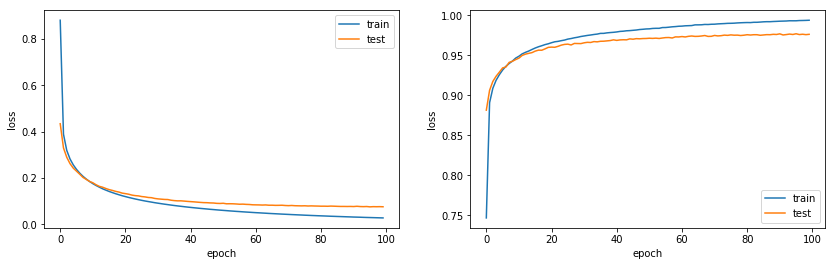

In [84]:
# Ploteamos los resultados del primer modelo:
show_results(model = model, log=log, cycling=False)

Ahora elaboramos una nuevo modelo de predicción que tome en cuenta a la técnica de *Learning Rate Finder* para decidir el valor del hiperparámetro **lr (learning rate)**:

In [46]:
# %load C:/Users/huama/Desktop/Proyectos Python/Clases DL PUCP/semana3/custom_callbacks.py
import keras, math
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
from pathlib import Path

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias'):
            if layer.bias and hasattr(layer, 'bias_initializer'): layer.bias.initializer.run(session=session)

class CycleLearner(keras.callbacks.Callback):
    def __init__(self, lr, nb, n_cycle, cycle_len=1, cycle_mult=1,
                 snapshots=False, n_snapshots=5,
                 snapshots_name='temp_model', snapshots_folder='snapshots'):
        super().__init__()
        self.lr = lr
        self.nb = nb*cycle_len
        self.n_cycle = n_cycle
        self.cycle_len = cycle_len
        self.cycle_mult = cycle_mult
        self.snapshots = snapshots
        self.n_snapshots = n_snapshots
        self.start_snaps = n_cycle - n_snapshots
        self.snapshots_name = snapshots_name
        self.snapshots_folder = Path(snapshots_folder)
        self.lr_log = []
        self.losses = []
        self.iterations = []
        if snapshots: self.snapshots_folder.mkdir(exist_ok=True)

    def on_train_begin(self, logs={}):
        self.iteration,self.epoch = 0,0
        self.cycle_iter,self.cycle_count=0,0
        self.update_lr()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_log.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)
        self.update_lr()
        if self.cycle_count == self.n_cycle:
            self.model.stop_training = True
    
    def on_cycle_end(self):
        self.cycle_iter = 0
        self.nb *= self.cycle_mult
        self.cycle_count += 1
        if self.snapshots and self.cycle_count>self.start_snaps:
            file = self.snapshots_folder / f'{self.snapshots_name}_{self.cycle_count}.hdf5'
            self.model.save_weights(file, overwrite=True)
    
    def update_lr(self):
        new_lr = self.calc_lr()
        K.set_value(self.model.optimizer.lr, new_lr)

    def calc_lr(self):
        if self.iteration<self.nb/20:
            self.cycle_iter += 1
            return self.lr/100.

        cos_out = np.cos(np.pi*(self.cycle_iter)/self.nb) + 1
        self.cycle_iter += 1
        if self.cycle_iter==self.nb:
            self.on_cycle_end()
            
        return self.lr / 2 * cos_out        
        
    def plot_loss(self, skip=10):
        plt.plot(self.iterations[skip:], self.losses[skip:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_log)


class LrFinder(keras.callbacks.Callback):
    def __init__(self, nb, start_lr=1e-5, end_lr=10):
        super().__init__()
        self.start_lr = start_lr
        self.lr = start_lr
        self.lr_mult = (end_lr/start_lr)**(1/nb)
        self.lr_log = []
        self.losses = []
        self.iterations = []
        
    def on_train_begin(self, logs={}):
        self.best = 1e9
        self.iteration = 0
        self.update_lr()

    def on_batch_end(self, batch, logs={}):
        self.iteration += 1
        self.lr_log.append(K.eval(self.model.optimizer.lr))
        loss = logs.get('loss')
        self.losses.append(loss)
        self.iterations.append(self.iteration)

        if math.isnan(loss) or loss>self.best*4:
            self.model.stop_training = True
        if loss<self.best:
            self.best=loss
        self.update_lr()
    
    def update_lr(self):
        new_lr = self.start_lr * (self.lr_mult**self.iteration)
        K.set_value(self.model.optimizer.lr, new_lr)
        
    def plot_loss(self):
        plt.plot(self.iterations[10:], self.losses[10:])

    def plot_lr(self):
        plt.xlabel("iterations")
        plt.ylabel("learning rate")
        plt.plot(self.iterations, self.lr_log)
        
    def plot(self, n_skip_start=2, xlim=None, ylim=None):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lr_log[n_skip_start:], self.losses[n_skip_start:])
        plt.xscale('log')
        if ylim is not None: plt.ylim(top=ylim)
        if xlim is not None: plt.xlim(right=xlim)
        

In [88]:
# Compilamos un nuevo modelo para realizar las comparaciones adecuadas con el modelo 1:

model_2 = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_2.compile(SGD(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

lr_finder = LrFinder(num_batches)
model_2.fit(x=x_train, y=y_train, batch_size=batch_size, callbacks=[lr_finder]) # Ajuste simple para sacar las graficas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
45056/60000 [=====================>........] - ETA: 0s - loss: 2.0027 - acc: 0.3137

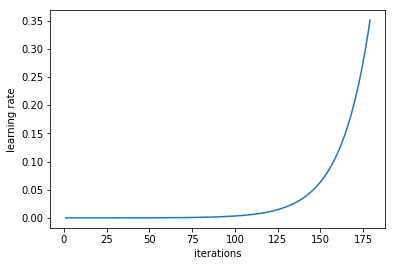

In [89]:
lr_finder.plot_lr()

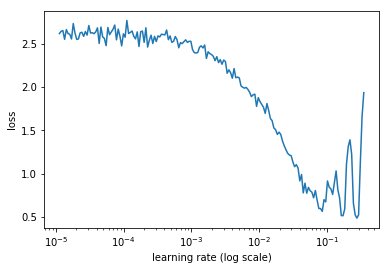

In [90]:
lr_finder.plot()

In [93]:
# Nuevo learning rate al ojo:
lr_2=3e-2

# Entrenamiento con el nuevo hiperparametro:
reset_weights(model_2)
model_2.compile(SGD(lr_2), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

log_2=model_2.fit(x_train, y_train, batch_size = batch_size, epochs=100, validation_data=[x_test, y_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 25us/step - loss: 0.5700 - acc: 0.8331 - val_loss: 0.2974 - val_acc: 0.9117
Epoch 2/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2723 - acc: 0.9195 - val_loss: 0.2642 - val_acc: 0.9186
Epoch 3/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.2193 - acc: 0.9358 - val_loss: 0.1969 - val_acc: 0.9420
Epoch 4/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1871 - acc: 0.9453 - val_loss: 0.1811 - val_acc: 0.9439
Epoch 5/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1653 - acc: 0.9529 - val_loss: 0.1545 - val_acc: 0.9532
Epoch 6/100
60000/60000 [==============================] - 1s 24us/step - loss: 0.1477 - acc: 0.9575 - val_loss: 0.1490 - val_acc: 0.9541
Epoch 7/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1344 - acc: 0.9616 - val_loss: 0.1319 - 

10000/10000 [==============================] - 0s 12us/step
Final Loss Value = 0.0869
Final Accuracy   = 0.9765


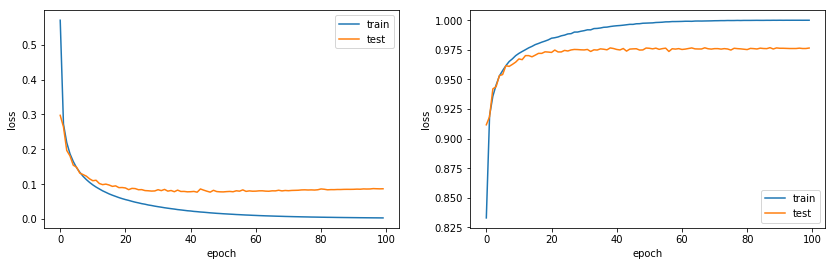

In [94]:
# Ploteamos los resultados del segundo modelo:
show_results(model = model_2, log=log_2, cycling=False)

Notamos que los esfuerzos por establecer un buen ratio de aprendizaje no tuvieron mucho impacto en la nueva solución, dada la naturaleza del problema. Entonces, podremos intentar otros ajustes a los demás hiperparametros, con la esperanza de poder mejorar el accuracy general.